# 1 Setting Up Environment

In [4]:
import isort
script_path = 'imports.py'
# Sorting the imports in the script
isort.file(script_path)
from imports import *
# For displaying plots inline
%matplotlib inline
from fredapi import Fred
api_key = '####################################'
fred = Fred(api_key=api_key)

# 2 Data Collection & Preparation

## 2.1 Fetching Data & Creating Stress Flag

### Fetching & Preparing Data Functions

In [5]:
def fetch_and_process_fred_data(fred, series_id, column_name):
    """
    Fetches a time series from FRED and prepares it for merging.

    Parameters:
    fred (Fred API client): The client used to fetch data from FRED.
    series_id (str): The FRED series ID to fetch.
    column_name (str): The name to assign to the fetched column.

    Returns:
    pd.DataFrame: Processed DataFrame with the time series data.
    """
    # Fetching the series from FRED and convert to DataFrame
    df = fred.get_series(series_id=series_id).to_frame().rename(columns={0: column_name})
    df.index = pd.to_datetime(df.index)  # Making sure index is datetime

    return df

def merge_with_date_range(date_range_df, *dataframes, date_col):
    """
    Merges multiple DataFrames containing time series data with a master date range DataFrame.

    Parameters:
    date_range_df (pd.DataFrame): A DataFrame containing the master date range.
    *dataframes: Variable number of DataFrames to merge with the master date range.
    date_col (str): The name of the date column in the master DataFrame.

    Returns:
    pd.DataFrame: The master DataFrame with all time series merged.
    """
    for df in dataframes:
        date_range_df = pd.merge(date_range_df, df, how='left', left_on = date_col, right_index=True)
    return date_range_df

def nullify_and_refill_quarterly_features(df, features, resample_period='M'):
    """
    Nullify and refill specified features in a DataFrame on a quarterly basis.

    This function sets the specified features to NaN for certain months and then
    refills these NaN values by resampling and interpolating the data.

    Parameters:
    df (pd.DataFrame): The input DataFrame with a DateTime index.
    features (list of str): List of feature names (columns) to be nullified and refilled.
    resample_period (str, optional): The period for resampling the data. Default is 'M' (monthly).

    Returns:
    pd.DataFrame: The DataFrame with the specified features nullified and refilled.
    """
    months_to_nullify = [2, 3, 5, 6, 8, 9, 11, 12]
    df.loc[df.index.month.isin(months_to_nullify), features] = np.nan
    for feature in features:
        df[feature] = df[feature].resample(resample_period).interpolate(method='linear')
    return df

### Economic Indicators & Threshold Definition Functions

In [6]:
def calculate_spread(df, ten_year: str, two_year: str):
    """
    Calculates the yield spread between two interest rates and adds it as a new column.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing the interest rate columns.
    ten_year (str): Column name for the 10-year interest rate.
    two_year (str): Column name for the 2-year interest rate.

    Returns:
    pd.DataFrame: DataFrame with the yield spread column added.
    """
    df['YIELD_SPREAD'] = df[ten_year] - df[two_year]
    return df

def set_rule_based_thresholds(df, recession_periods, target_column, threshold):
    """
    Applies rule-based thresholds to a DataFrame to identify stress periods and sets a target column.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing economic indicators.
    recession_periods (list of tuples): List of tuples defining known recession periods (start, end).
    target_column (str): Name of the column to store the stress flag (default: 'stress_flag').
    threshold (int): Minimum number of conditions that need to be met for a row to be flagged as stress (default: 3).

    Returns:
    pd.DataFrame: DataFrame with the stress flag column added.
    """

    # Initializing a column to count the number of stress conditions met
    df['outlier_count'] = 0

    # Calculating year-over-year growth rates for CPI, INDPRO and House Price Index
    df['yoy_cpi_growth'] = (df['CPI'] - df['CPI'].shift(12)) / df['CPI'].shift(12)
    df['yoy_indpro_growth'] = (df['INDPRO'] - df['INDPRO'].shift(12)) / df['INDPRO'].shift(12)
    df['yoy_house_price_index_growth'] = (df['HOUSE_PRICE_INDEX'] - df['HOUSE_PRICE_INDEX'].shift(12)) / df['HOUSE_PRICE_INDEX'].shift(12)

    # Defining conditions for stress thresholds
    conditions = [
        (df['YIELD_SPREAD'] <= 0),                                              # Yield curve inversion indicates potential recession and economic slowdown.
        (df['GDP'] <= 0),                                                       # Negative GDP growth signals an economic contraction or recession.
        (df['UEMP_RATE'] >= 6),                                                 # High unemployment rate reflects reduced consumer spending and economic distress.
        (df['yoy_cpi_growth'] >= 0.05),                                         # High CPI year-over-year growth indicates inflationary pressures.
        (df['NFCI'] >= 0.5),                                                    # NFCI >= 0.5 shows tightened financial conditions affecting liquidity and credit.
        (df['yoy_indpro_growth'] <= -0.02),                                     # Decline in industrial production highlights weakening manufacturing activity.
        (df['yoy_house_price_index_growth'] <= -0.05),                          # Falling house prices increase risks for real estate loans and defaults.
        (df['BAA_CORPORATE_BOND_YIELD_SPREAD_OVER_TEN_YEAR_TREASURY'] >= 2),    # Credit spread widening reflects increased risk perception.
        (df['VIX'] >= 25)                                                       # High volatility index (VIX) suggests economic uncertainty and risk aversion.
    ]


    # Incrementing the outlier count for each condition met
    for condition in conditions:
        df['outlier_count'] += np.where(condition, 1, 0)

    # Setting the target column to 1 if the number of conditions met exceeds the threshold
    df[target_column] = np.where(df['outlier_count'] >= threshold, 1, 0)

    # Marking recession periods with a flag of 2, this is a temporary value, the aim is to differentiate between stress and recession events for further pre-model analysis.
    for start, end in recession_periods:
        df.loc[(df.index >= start) & (df.index <= end), target_column] = 2

    # Dropping intermediate columns used only for calculations
    df.drop(columns=['outlier_count', 'yoy_cpi_growth', 'yoy_indpro_growth', 'yoy_house_price_index_growth'], inplace=True)

    return df

### Main Functions

In [7]:
def fetch_data(series_info, aggregation_rules, date_col, start_date, end_date, freq_value, agg_rule, resample_rule):
    """
    Fetches and processes financial and economic time series data, resamples it to a specified frequency,
    and applies aggregation rules.

    Parameters:
        series_info (list of tuples): List of tuples where each tuple contains a series ID and its corresponding column name.
        aggregation_rules (dict): Dictionary mapping feature names to their respective aggregation methods (e.g., 'mean', 'last').
        date_col (str): Name of the date column.
        start_date (str): Start date for the date range (e.g., '1990-01-01').
        end_date (str): End date for the date range (e.g., '2024-07-01').
        freq_value (str): Frequency of the original data (e.g., 'D' for daily, 'W' for weekly).
        agg_rule (str): Default aggregation rule to apply for features not explicitly listed in `aggregation_rules`.
        resample_rule (str): Resampling frequency (e.g., 'M' for monthly, 'Q' for quarterly).

    Returns:
        pd.DataFrame: A DataFrame resampled and aggregated according to the specified rules.
    """
    # Fetching and processing each series
    processed_data = []
    for series_id, column_name in series_info:
        processed_data.append(fetch_and_process_fred_data(fred, series_id, column_name))

    # Creating a complete date range DataFrame
    date_range = pd.date_range(start=start_date, end=end_date, freq=freq_value)
    df_dates = pd.DataFrame(date_range, columns=[date_col])

    # Merging all time series data with the complete date range
    df = merge_with_date_range(df_dates, *processed_data, date_col=date_col)
    df[date_col] = pd.to_datetime(df[date_col])                                 # Ensure the date column is in datetime format
    df.set_index(date_col, inplace=True)                                        # Setting the date column as the DataFrame index

    # Adding default aggregation rules for columns not explicitly listed
    for column in df.columns:
        if column not in aggregation_rules:
            aggregation_rules[column] = agg_rule

    # Resampling and aggregating data based on the specified rules
    monthly_df = df.resample(resample_rule).agg(aggregation_rules)

    # Converting the index to a 'yyyy-mm' period format for clarity
    monthly_df.index = monthly_df.index.to_period(resample_rule)

    return monthly_df

In [8]:
def fetch_economic_data():
    """
    Fetches and processes economic indicators to prepare a resampled, aggregated, and engineered dataset.

    The function retrieves data, resamples it to a monthly frequency, calculates derived features (e.g., yield spread), 
    and applies rule-based thresholds to identify stress flags.

    Returns:
        pd.DataFrame: A DataFrame containing resampled, aggregated, and processed economic indicators.
    """
    # Defining economic data series information
    series_info = [
        ('DGS10', 'TEN_YEAR_TREASURY_YIELD'),                                   # Daily data: 10-Year Treasury Yield
        ('DGS2', 'TWO_YEAR_TREASURY_YIELD'),                                    # Daily data: 2-Year Treasury Yield
        ('BAA10Y', 'BAA_CORPORATE_BOND_YIELD_SPREAD_OVER_TEN_YEAR_TREASURY'),   # Daily data: Credit Spreads
        ('A191RL1Q225SBEA', 'GDP'),                                             # Quarterly data: GDP
        ('UNRATE', 'UEMP_RATE'),                                                # Monthly data: Unemployment Rate
        ('CPIAUCSL', 'CPI'),                                                    # Monthly data: Consumer Price Index
        ('NFCI', 'NFCI'),                                                       # Weekly data: National Financial Conditions Index
        ('INDPRO', 'INDPRO'),                                                   # Monthly data: Industrial Production Index
        ('VIXCLS', 'VIX'),                                                      # Monthly data: Stock Market ABS_GR
        ('USSTHPI', 'HOUSE_PRICE_INDEX')                                        # Quarterly data: House Price Index
    ]

    # Defining recession periods for stress flagging
    recession_periods = [
        ('1990-07', '1991-03'),
        ('2001-03', '2001-11'),
        ('2007-12', '2009-06'),
        ('2020-02', '2020-04')
    ]

    # Quarterly features that require specific handling
    features = ['GDP', 'HOUSE_PRICE_INDEX']

    aggregation_rules = {
        'TEN_YEAR_TREASURY_YIELD': 'mean',                                  # Use average for daily yields
        'TWO_YEAR_TREASURY_YIELD': 'mean',                                  # Use average for daily yields
        'BAA_CORPORATE_BOND_YIELD_SPREAD_OVER_TEN_YEAR_TREASURY': 'mean',   # Average for credit spreads
        'NFCI': 'mean'                                                      # Average for financial conditions index
    }

    # Defining date and resampling parameters
    date_col = 'DATE'
    start_date = '1987-01-01'
    end_date = '2024-07-01'
    freq = 'D'                                                              # Daily data
    agg_rule = 'last'                                                       # Default aggregation rule for unspecified features
    resample_rule = 'M'                                                     # Resample to monthly frequency

    # Fetch, resample, and aggregate data
    monthly_df = fetch_data(series_info, 
                            aggregation_rules, 
                            date_col, 
                            start_date, 
                            end_date, 
                            freq, 
                            agg_rule, 
                            resample_rule)

    monthly_df = calculate_spread(monthly_df, 'TEN_YEAR_TREASURY_YIELD', 'TWO_YEAR_TREASURY_YIELD')
    
    # Handling missing values by forward and backward filling as well as handling missing values of quarterly features using linear interpolation technique
    monthly_df = nullify_and_refill_quarterly_features(monthly_df, features)
    monthly_df = monthly_df.replace(0, np.nan).fillna(method='ffill').fillna(method='bfill')

    # Applying rule-based thresholds to determine stress flags
    monthly_df = set_rule_based_thresholds(monthly_df, recession_periods, 'STRESS_FLAG', 3)

    return monthly_df

In [9]:
def fetch_financial_data():
    """
    Fetches and processes financial indicators to prepare a resampled, aggregated, and cleaned dataset.

    The function retrieves financial data, resamples it to a monthly frequency, applies aggregation rules, 
    and fills missing values using forward and backward filling to ensure completeness.

    Returns:
        pd.DataFrame: A DataFrame containing resampled, aggregated, and cleaned financial indicators.
    """
    # Step 1: Define financial data series information
    series_info = [
        ('FEDFUNDS', 'INTEREST_RATE'),                  # Monthly: Federal Funds Rate (%)
        ('LOANS', 'TOTAL_LOANS'),                       # Monthly: Total Loans (Billions)
        ('DPSACBM027NBOG', 'TOTAL_DEPOSITS'),           # Monthly: Total Deposits (Billions)
        ('REALLN', 'REAL_ESTATE_LOANS'),                # Monthly: Real Estate Loans (Billions)
        ('BORROW', 'TOTAL_BANK_BORROWINGS'),            # Monthly: Total Bank Borrowings (Millions)
        ('BUSLOANS', 'BUSINESS_LOANS'),                 # Monthly: Business Loans (Billions)
        ('DRALACBN', 'DELINQUENCY_RATES_LOANS'),        # Quarterly: Delinquency Rates (%)
        ('NONBORRES', 'NON_BORROWED_RESERVES'),         # Monthly: Non-Borrowed Reserves (Billions)
        ('TOTALSL', 'CONSUMER_LOANS'),                  # Monthly: Consumer Loans (Billions)
        ('LTDACBW027SBOG', 'TIME_DEPOSITS'),            # Weekly: Time Deposits (Billions)
        ('CORCACBN', 'LOAN_CHARGE_OFF'),                # Quarterly: Loan Charge-Off Rates (%)
        ('QBPBSTLKTEQKTBKEQK', 'TOTAL_EQUITY_CAPITAL'), # Quarterly: Total Equity Capital (Millions)
        ('TLAACBM027NBOG', 'TOTAL_ASSETS'),             # Monthly: Total Assets (Billions)
        ('QBPBSTASTLNLESSRES', 'RESERVE_FOR_LOSSES'),   # Quarterly: Total Loans and Leases: Less: Reserve for Losses (Millions)
        ('QBPQYNTIY', 'NET_INTEREST_INCOME')            # Quarterly: Net Interest Income (Millions)
    ]

    # Quarterly features that require specific handling
    features = ['DELINQUENCY_RATES_LOANS', 'LOAN_CHARGE_OFF', 'TOTAL_EQUITY_CAPITAL', 'NET_INTEREST_INCOME', 'RESERVE_FOR_LOSSES']

    # Defining aggregation rules for specific series
    aggregation_rules = {}

    # Defining date and resampling parameters
    date_col = 'DATE'               # Date column name
    start_date = '1987-01-01'       # Start date for the data
    end_date = '2024-07-01'         # End date for the data
    freq = 'D'                      # Original frequency of the data (daily)
    agg_rule = 'last'               # Default aggregation rule for unspecified series
    resample_rule = 'M'             # Resample to monthly frequency

    # Fetch, resample, and aggregate data
    monthly_df = fetch_data(
        series_info,
        aggregation_rules,
        date_col,
        start_date,
        end_date,
        freq,
        agg_rule,
        resample_rule
    )

    # Handling missing values by forward and backward filling as well as handling missing values of quarterly features using linear interpolation technique
    monthly_df = nullify_and_refill_quarterly_features(monthly_df, features)
    monthly_df = monthly_df.replace(0, np.nan).fillna(method='ffill').fillna(method='bfill')

    return monthly_df

In [10]:
def run():
    """
    Combines economic and financial data with a shared stress flag.

    Workflow:
    1. Fetch and process economic indicators using `fetch_economic_data`.
    2. Fetch and process financial indicators using `fetch_financial_data`.
    3. Merge the stress flag from the economic data into the financial data.
    4. Return the final DataFrame containing financial data and the stress flag.

    Returns:
    pd.DataFrame: Combined DataFrame with financial indicators and the stress flag.
    """
    # Fetching economic data
    e_df = fetch_economic_data()

    # Fetching financial data
    f_df = fetch_financial_data()
    
    target_feature = ['STRESS_FLAG']
    # Merging stress flag from economic data into financial data
    # Financial data is the data that will be used for this project, where the aim is to predict stress events based on internal financial/banking indicators
    f_df[target_feature] = e_df[target_feature]

    return f_df, e_df

df, e_df = run()

In [350]:
# Making sure data is clean and doesn't contain any null values.
if df.isna().sum().sum() == 0:
    print("Financial Data is clean!")

if e_df.isna().sum().sum() == 0:
    print("Economic Data is clean!")

Financial Data is clean!
Economic Data is clean!


## 2.2 FE

In [351]:
def fill_zero_value(df, feature):
    """
    Replaces zero values in a specified feature column with NaN, then fills the NaN values using
    forward fill and backward fill methods.

    This function is useful for handling features where zero values are invalid or represent missing data.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the feature to process.
    feature (str): The name of the feature column to process.

    Returns:
    pd.Series: The processed column with zero values replaced and missing values filled.
    """
    df[feature] = df[feature].replace(0, np.nan).fillna(method='ffill').fillna(method='bfill')
    return df[feature]

def additional_feature_engineering(df, target_column):
    """
    Performs additional feature engineering to derive new economic indicators and ratios from the existing dataset.

    Feature Descriptions and Benefits:

    The definition and calculation of the below features has been gathered from various research papers.
    The aim was to calculate all of these features and perform analysis on them and see which features will be relevant the most for this project.

    1.  'LDR': Loan-to-Deposit Ratio. Indicates liquidity and lending practices; higher values suggest potential liquidity stress.
    2.  'DDR': Debt-to-Deposit Ratio. Highlights reliance on borrowings relative to deposits; essential for funding stability analysis.
    3.  'REAL_ESTATE_LOAN_RATIO': Proportion of loans in real estate. Identifies exposure to housing market risks.
    4.  'BUSINESS_LOANS_RATIO': Proportion of loans in business credit. Captures sensitivity to business sector performance.
    5.  'CONSUMER_LOANS_RATIO': Proportion of loans in consumer credit. Indicates risks tied to consumer-driven downturns.
    6.  'BORROWINGS_LOAN_RATIO': Ratio of borrowings to total loans. Reflects dependency on external funding for lending activities.
    7.  'TDR': Time Deposit Ratio. Assesses liquidity constraints due to deposits locked in time-based accounts.
    8.  'LAR': Loan-to-Asset Ratio. Highlights lending practices relative to overall assets; signals balance sheet risk.
    9.  'RESERVE_TO_LOAN_RATIO': Adequacy of reserves relative to loans. Monitors reserve sufficiency to cover loan losses.
    10. 'RESERVE_TO_DEPOSIT_RATIO': Adequacy of reserves relative to deposits. Tracks reserve sufficiency for depositor demands.
    11. 'RESERVE_SENSITIVITY': Interaction of reserves and interest rates. Reflects reserve responsiveness to macroeconomic changes.
    12. 'RESERVE_UTILIZATION_RATE': Proportion of reserves utilized relative to assets. Indicates reserve coverage for financial operations.
    13. 'RESERVE_TO_BORROWING_RATIO': Reserves relative to borrowings. Monitors the reserve buffer against external borrowings.
    14. 'RESERVE_COVERAGE_INDEX': Combined measure of reserve adequacy relative to deposits and borrowings.
    15. 'RESERVE_ADJUSTMENT_INDEX': Adjusted measure of reserve sensitivity considering utilization rate.
    16. 'RESERVE_STRESS_INDEX': Measure of reserve stress considering utilization rate and borrowing ratio.
    17. 'RESERVE_LIQUIDITY_INDEX': Combined measure of reserve liquidity relative to deposits and borrowings.
    18. 'LIQUIDITY_RISK_INDEX': Average of LDR, TDR, and DDR. Indicates overall liquidity risk.
    19. 'RISK_WEIGHTED_LENDING': Measure of risk-weighted lending practices.
    20. 'ASSET_COVERAGE_INDEX': Measure of asset coverage considering reserve to deposit ratio.
    21. 'LOAN_LIQUIDITY_INDEX': Measure of loan liquidity considering reserve utilization rate.
    22. 'DER': Debt-to-Equity Ratio. Indicates financial leverage and stability.
    23. 'ROA': Return on Assets. Measures profitability relative to total assets.
    24. 'INTEREST_MARGIN_RATIO': Interest Margin Ratio. Measures profitability from interest-earning assets.
    25. 'EQUITY_TO_LOAN_RATIO': Equity to Loan Ratio. Indicates capital adequacy relative to loans.
    26. 'INTEREST_RATE': Interest rate. Influences borrowing costs and liquidity management.
    27. 'DELINQUENCY_RATES_LOANS': Loan delinquency rates. Tracks deteriorating loan performance and credit stress.
    28. 'LOAN_CHARGE_OFF': Percentage of loans written off. Indicates severe credit performance issues.
    29. 'TOTAL_EQUITY_CAPITAL': Total equity as a buffer against losses. Measures financial stability and capital adequacy.
    30. 'NET_INTEREST_INCOME': Net interest income. Key revenue source from interest-earning assets.

    Args:
        df (pd.DataFrame): Input DataFrame containing the required features for calculations.
            Required columns:
                - 'TOTAL_LOANS'
                - 'TOTAL_BANK_BORROWINGS'
                - 'TOTAL_DEPOSITS'
                - 'REAL_ESTATE_LOANS'
                - 'BUSINESS_LOANS'
                - 'NON_BORROWED_RESERVES'
                - 'CONSUMER_LOANS'
                - 'TIME_DEPOSITS'
                - 'TOTAL_EQUITY_CAPITAL'
                - 'TOTAL_ASSETS'
                - 'INTEREST_RATE'
                - 'DELINQUENCY_RATES_LOANS'
                - 'LOAN_CHARGE_OFF'
                - 'RESERVE_FOR_LOSSES'
                - 'NET_INTEREST_INCOME'
        target_column (str): The name of the target column.

    Returns:
        pd.DataFrame: The updated DataFrame with additional engineered features.
    """

    # Replacing zero values and fill missing values for key features (making sure the denominators of the below ratios have non-zero values.)
    key_features = [
        'TOTAL_LOANS', 'TOTAL_DEPOSITS', 'TOTAL_BANK_BORROWINGS', 'TOTAL_ASSETS',
        'LOAN_CHARGE_OFF', 'TOTAL_EQUITY_CAPITAL', 'NET_INTEREST_INCOME'
    ]
    for feature in key_features:
        df[feature] = fill_zero_value(df, feature)

    # Financial Ratios
    df['LDR'] = df['TOTAL_LOANS'] / df['TOTAL_DEPOSITS']                                                    # Loan-to-Deposit Ratio
    df['DDR'] = (df['TOTAL_BANK_BORROWINGS'] * 0.001) / df['TOTAL_DEPOSITS']                                # Debt-to-Deposit Ratio (converted to billions)
    df['REAL_ESTATE_LOAN_RATIO'] = df['REAL_ESTATE_LOANS'] / df['TOTAL_LOANS']                              # Real Estate Loan Ratio
    df['BUSINESS_LOANS_RATIO'] = df['BUSINESS_LOANS'] / df['TOTAL_LOANS']                                   # Business Loans Ratio
    df['CONSUMER_LOANS_RATIO'] = df['CONSUMER_LOANS'] / df['TOTAL_LOANS']                                   # Consumer Loans Ratio
    df['BORROWINGS_LOAN_RATIO'] = (df['TOTAL_BANK_BORROWINGS'] * 0.001) / df['TOTAL_LOANS']                 # Borrowings to Loan Ratio (converted to billions)
    df['TDR'] = df['TIME_DEPOSITS'] / df['TOTAL_DEPOSITS']                                                  # Time Deposit Ratio
    df['LAR'] = df['TOTAL_LOANS'] / df['TOTAL_ASSETS']                                                      # Loan-to-Asset Ratio

    # RESERVE Feature Engineering
    df['RESERVE_TO_LOAN_RATIO'] = df['NON_BORROWED_RESERVES'] / df['TOTAL_LOANS']                           # Reserve to Loan Ratio
    df['RESERVE_TO_DEPOSIT_RATIO'] = df['NON_BORROWED_RESERVES'] / df['TOTAL_DEPOSITS']                     # Reserve to Deposit Ratio
    df['RESERVE_SENSITIVITY'] = df['NON_BORROWED_RESERVES'] * df['INTEREST_RATE']                           # Reserve Sensitivity
    df['RESERVE_UTILIZATION_RATE'] = df['NON_BORROWED_RESERVES'] / df['TOTAL_ASSETS']                       # Reserve Utilization Rate
    df['RESERVE_TO_BORROWING_RATIO'] = df['NON_BORROWED_RESERVES'] / df['TOTAL_BANK_BORROWINGS']            # Reserve to Borrowing Ratio
    df['RESERVE_COVERAGE_INDEX'] = df['RESERVE_TO_DEPOSIT_RATIO'] * df['RESERVE_TO_BORROWING_RATIO']        # Reserve Coverage Index
    df['RESERVE_ADJUSTMENT_INDEX'] = df['RESERVE_SENSITIVITY'] / (1 + df['RESERVE_UTILIZATION_RATE'])       # Reserve Adjustment Index
    df['RESERVE_STRESS_INDEX'] = df['RESERVE_UTILIZATION_RATE'] * (1 - df['RESERVE_TO_BORROWING_RATIO'])    # Reserve Stress Index
    df['RESERVE_LIQUIDITY_INDEX'] = df['RESERVE_TO_DEPOSIT_RATIO'] + df['RESERVE_TO_BORROWING_RATIO']       # Reserve Liquidity Index

    # Additional Financial Feature Engineering
    df['LIQUIDITY_RISK_INDEX'] = (df['LDR'] + df['TDR'] + df['DDR']) / 3                                    # Liquidity Risk Index
    df['RISK_WEIGHTED_LENDING'] = df['LAR'] * df['BORROWINGS_LOAN_RATIO']                                   # Risk-Weighted Lending
    df['ASSET_COVERAGE_INDEX'] = df['LAR'] / (1 + df['RESERVE_TO_DEPOSIT_RATIO'])                           # Asset Coverage Index
    df['LOAN_LIQUIDITY_INDEX'] = df['LAR'] * (1 - df['RESERVE_UTILIZATION_RATE'])                           # Loan Liquidity Index
    df['DER'] = df['TOTAL_BANK_BORROWINGS'] / df['TOTAL_EQUITY_CAPITAL']                                    # Debt-to-Equity Ratio
    df['ROA'] = (df['NET_INTEREST_INCOME'] * 0.001) / df['TOTAL_ASSETS']                                    # Return on Assets (converted to billions)
    df['INTEREST_MARGIN_RATIO'] = (df['NET_INTEREST_INCOME'] * 0.001) / df['TOTAL_LOANS']                   # Interest Margin Ratio (converted to billions)
    df['EQUITY_TO_LOAN_RATIO'] = (df['TOTAL_EQUITY_CAPITAL'] * 0.001) / df['TOTAL_LOANS']                   # Equity to Loan Ratio (converted to billions)

    # Selecting features for the final DataFrame
    selected_features = [target_column] + [ 
                                            'NET_INTEREST_INCOME',
                                            'EQUITY_TO_LOAN_RATIO',
                                            'INTEREST_MARGIN_RATIO',
                                            'ROA',
                                            'DER',
                                            'LOAN_LIQUIDITY_INDEX',
                                            'ASSET_COVERAGE_INDEX',
                                            'RISK_WEIGHTED_LENDING',
                                            'RESERVE_LIQUIDITY_INDEX',
                                            'RESERVE_STRESS_INDEX',
                                            'RESERVE_ADJUSTMENT_INDEX',
                                            'RESERVE_COVERAGE_INDEX',
                                            'RESERVE_TO_BORROWING_RATIO',
                                            'RESERVE_UTILIZATION_RATE',
                                            'RESERVE_SENSITIVITY',
                                            'LAR',
                                            'TDR',
                                            'BORROWINGS_LOAN_RATIO',
                                            'LDR',                     
                                            'DDR',                     
                                            'REAL_ESTATE_LOAN_RATIO',  
                                            'RESERVE_TO_LOAN_RATIO',   
                                            'RESERVE_TO_DEPOSIT_RATIO',
                                            'LIQUIDITY_RISK_INDEX',    
                                            'INTEREST_RATE',           
                                            'DELINQUENCY_RATES_LOANS', 
                                            'LOAN_CHARGE_OFF'          
                                        ]          

    df = df[selected_features]
    return df

fe_df = additional_feature_engineering(df, 'STRESS_FLAG')

## 2.3 Lagging Features & Creating Rolling Growth Rate Features

In [353]:
def lag_features(df, t1, t2, t3, t4, target_column='STRESS_FLAG', start='1990-01', end='2024-07', keyword='LAG'):
    """
    Create lagged features for the input DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame.
        target_column (str): Column name of the target variable to exclude from lagging.
        t1 (int): Lag period for the first lag.
        t2 (int): Lag period for the second lag.
        t3 (int): Lag period for the third lag.
        t4 (int): Lag period for the fourth lag.
        start (str): Start date for filtering the DataFrame after creating lags.
        end (str): End date for filtering the DataFrame after creating lags.
        keyword (str): Keyword to use for naming lagged features.

    Returns:
        pd.DataFrame: DataFrame with lagged features and filtered by the specified date range.
    """
    for feature in df.columns:
        if target_column not in feature:
            df[f'{keyword}_{t1}_{feature}'] = df[feature].shift(t1)
            df[f'{keyword}_{t2}_{feature}'] = df[feature].shift(t2)
            df[f'{keyword}_{t3}_{feature}'] = df[feature].shift(t3)
            df[f'{keyword}_{t4}_{feature}'] = df[feature].shift(t4)
    
    df = df[(df.index >= start) & (df.index <= end)]
    return df

def calculate_gm_gr(df, l1, l2, l3, l4, features_require_sign, features_no_sign, keyword='GR', lag_word='LAG', target_col='STRESS_FLAG'):
    """
    Calculate Geometric Mean of Month-to-Month Growth Rate for lagged features, considering sign for specific features.

    Args:
        df (pd.DataFrame): Input DataFrame containing lagged features.
        l1 (str): Prefix for one-month lagged features.
        l2 (str): Prefix for two-month lagged features.
        l3 (str): Prefix for three-month lagged features.
        l4 (str): Prefix for four-month lagged features.
        features_require_sign (list): List of features that require sign consideration.
        features_no_sign (list): List of features that do not require sign consideration.
        keyword (str): Keyword to use for naming ABS_GR features.
        lag_word (str): Keyword to exclude lag-related columns.
        target_col (str): Column to exclude from processing.

    Returns:
        pd.DataFrame: DataFrame with added ABS_GR features.
    """
    for feature in df.columns:
        if target_col not in feature and lag_word not in feature:
            if feature in features_no_sign:
                # Handling features without sign
                df[f'M0M1_{keyword}_{feature}'] = ((df[f'{l1}_{feature}'] - df[f'{l2}_{feature}']) / df[f'{l2}_{feature}'].replace(0, 1e-9)).abs()
                df[f'M1M2_{keyword}_{feature}'] = ((df[f'{l2}_{feature}'] - df[f'{l3}_{feature}']) / df[f'{l3}_{feature}'].replace(0, 1e-9)).abs()
                df[f'M2M3_{keyword}_{feature}'] = ((df[f'{l3}_{feature}'] - df[f'{l4}_{feature}']) / df[f'{l4}_{feature}'].replace(0, 1e-9)).abs()
            elif feature in features_require_sign:
                # Handling features with sign
                df[f'M0M1_{keyword}_{feature}'] = (df[f'{l1}_{feature}'] - df[f'{l2}_{feature}']) / df[f'{l2}_{feature}'].replace(0, 1e-9)
                df[f'M1M2_{keyword}_{feature}'] = (df[f'{l2}_{feature}'] - df[f'{l3}_{feature}']) / df[f'{l3}_{feature}'].replace(0, 1e-9)
                df[f'M2M3_{keyword}_{feature}'] = (df[f'{l3}_{feature}'] - df[f'{l4}_{feature}']) / df[f'{l4}_{feature}'].replace(0, 1e-9)

            # Geometric mean calculation
            formula = ((((df[f'M0M1_{keyword}_{feature}'].abs() + 1) * 
                         (df[f'M1M2_{keyword}_{feature}'].abs() + 1) * 
                         (df[f'M2M3_{keyword}_{feature}'].abs() + 1))**(1/3)) - 1) * 100
            
            if feature in features_require_sign:
                # Calculating net growth from l4 to l1
                net_growth = (df[f'{l1}_{feature}'] - df[f'{l4}_{feature}']) / df[f'{l4}_{feature}'].replace(0, 1e-9)
                overall_sign = np.sign(net_growth)
                formula *= overall_sign  # Applying the overall sign from net growth

            df[f'{keyword}_MAGNITUDE_{feature}'] = formula

            # Dropping intermediate columns
            df.drop(columns=[f'M0M1_{keyword}_{feature}', f'M1M2_{keyword}_{feature}', f'M2M3_{keyword}_{feature}'], inplace=True)
    
    return df

def lagging_and_calculating_gm_gr(fe_df, t1=1, t2=2, t3=3, t4=4, interaction_keyword = 'GR_', target_col='STRESS_FLAG'):
    """
    Apply lagging functions and calculate rolling ABS_GR on the given DataFrame.

    Args:
        fe_df (pd.DataFrame): The input DataFrame containing the features.
        t1 (int): The first lag period.
        t2 (int): The second lag period.
        t3 (int): The third lag period.
        t4 (int): The fourth lag period.
        interaction_keyword (str): String Value that is added to the column name.
        target_col (str): Column name of the target variable.

    Returns:
        pd.DataFrame: The resulting DataFrame after applying lag functions and calculating ABS_GR.
    """

    features_require_sign = [
                                'EQUITY_TO_LOAN_RATIO', 'INTEREST_MARGIN_RATIO', 'ROA', 'DER', 
                                'REAL_ESTATE_LOAN_RATIO', 'INTEREST_RATE', 'DELINQUENCY_RATES_LOANS', 'LOAN_CHARGE_OFF'
                            ]
    features_no_sign = [
                            'NET_INTEREST_INCOME', 'LOAN_LIQUIDITY_INDEX', 'ASSET_COVERAGE_INDEX', 
                            'RISK_WEIGHTED_LENDING', 'RESERVE_LIQUIDITY_INDEX', 'RESERVE_STRESS_INDEX', 
                            'RESERVE_ADJUSTMENT_INDEX', 'RESERVE_COVERAGE_INDEX', 'RESERVE_TO_BORROWING_RATIO', 
                            'RESERVE_UTILIZATION_RATE', 'RESERVE_SENSITIVITY', 'LAR', 'TDR', 
                            'BORROWINGS_LOAN_RATIO', 'LDR', 'DDR', 'RESERVE_TO_LOAN_RATIO', 
                            'RESERVE_TO_DEPOSIT_RATIO', 'LIQUIDITY_RISK_INDEX'
                        ]

    lag_df = lag_features(fe_df, t1, t2, t3, t4)
    
    gm_abs_gr_df = calculate_gm_gr(lag_df, f'LAG_{t1}', f'LAG_{t2}', f'LAG_{t3}', f'LAG_{t4}', features_require_sign, features_no_sign)
        
    cols_to_drop = [col_name for col_name in gm_abs_gr_df.columns if interaction_keyword not in col_name and target_col not in col_name]
    
    gm_abs_gr_df.drop(columns=cols_to_drop, inplace=True)
    
    return gm_abs_gr_df

lag_gr_df = lagging_and_calculating_gm_gr(fe_df)


In [354]:
if lag_gr_df.isna().sum().sum() == 0:
    print("Data is clean!")

Data is clean!


## 2.4 Handling Multicollinearity

In [355]:
def apply_boxcox(df):
    """
    Applies Box-Cox transformation, standardization (Z-score), and normalization (-1 to 1)
    to each column in the DataFrame. Adds a new column for normalized z-scores.

    Args:
        df (pd.DataFrame): Input DataFrame with features to be transformed.

    Returns:
        pd.DataFrame: DataFrame with added normalized z-score columns.
        dict: A dictionary mapping column names to their corresponding Box-Cox lambda values.
    """
    df = df[(df.index >= '1990-01') & (df.index <='2024-10')]
    # Dictionary to store lambda values for Box-Cox transformation
    lambda_dict = {}
    
    # Iterating over each column
    for col_name in df.columns:
        feature = df[col_name]
        
        # Ensuring positive values for Box-Cox
        if feature.min() <= 0:
            shift = abs(feature.min()) + 1e-9
            feature = feature + shift

        # Applying Box-Cox transformation
        boxcox_transformed, lambda_ = boxcox(feature)
        lambda_dict[col_name] = lambda_  # Storing the lambda value if needed later on
        
        # Calculating Z-scores
        zscore = (boxcox_transformed - np.mean(boxcox_transformed)) / np.std(boxcox_transformed)
        
        # Normalizing Z-scores to [-1, 1]
        scaler = MinMaxScaler(feature_range=(-1, 1))
        normalized = scaler.fit_transform(zscore.reshape(-1, 1)).flatten()
        
        # Adding normalized z-score as a new column
        df[f'{col_name}_NORMALIZED_ZSCORE'] = normalized
    
    return df, lambda_dict

def compute_vif(df):
    """
    Computes Variance Inflation Factor (VIF) for each feature in the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing features (no target column).

    Returns:
        pd.DataFrame: DataFrame with features and their respective VIF scores.
    """
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

def iterative_vif(df, threshold):
    """
    Iteratively removes features with high VIF until all remaining features have VIF < threshold.
    This is done because we have a high dimensionality dataset and removing multicollinearity is essential.

    Args:
        df (pd.DataFrame): DataFrame containing the features.
        threshold (float): VIF threshold for feature removal.

    Returns:
        pd.DataFrame: DataFrame with reduced multicollinearity.
    """
    vif_results = compute_vif(df)

    while vif_results["VIF"].max() > threshold:
        high_vif_feature = vif_results.loc[vif_results["VIF"].idxmax(), "Feature"]
        print(f"Removing feature: {high_vif_feature} (VIF: {vif_results['VIF'].max()})")
        
        # Ensuring the column exists before dropping
        if high_vif_feature in df.columns:
            df = df.drop(columns=[high_vif_feature])
        else:
            print(f"Column {high_vif_feature} not found in DataFrame. Skipping...")
        
        # Recomputing VIF after dropping the feature
        vif_results = compute_vif(df)
    
    return df

def handle_multicollinearity(df, threshold_value, target_column, key_word):
    """
    Handles multicollinearity by applying Box-Cox transformation, filtering by VIF threshold, and retaining relevant columns.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - threshold_value (float): VIF threshold to identify multicollinearity.
    - target_column (str): The name of the target column.
    - key_word (str): Keyword used to filter specific columns.

    Returns:
    - pd.DataFrame: The DataFrame with reduced multicollinearity.
    """
    # Applying Box-Cox transformation to normalize the data
    vif_df, _ = apply_boxcox(df.drop(columns=[target_column]))

    # Retaining columns that contain the specified keyword
    cols_to_drop = [col_name for col_name in vif_df.columns if key_word not in col_name]
    vif_df.drop(columns=cols_to_drop, inplace=True)

    # Iteratively removing features with high VIF based on the threshold
    vif_df = iterative_vif(vif_df, threshold_value)

    # Removing the keyword suffix from the column names
    vif_df.columns = [col_name.replace(f'_{key_word}', '') for col_name in vif_df.columns]

    # Defining the columns to retain, including the target column
    cols_to_select = vif_df.columns.tolist() + [target_column]

    # Validating that the target column exists and columns to select are not empty
    if target_column not in df.columns:
        raise KeyError(f"{target_column} is missing in df")

    if len(cols_to_select) == 0:
        raise ValueError("No columns selected for retention. Check vif_df.columns.")

    # Dropping columns that are not in the selected list
    cols_to_drop = [col_name for col_name in df.columns if col_name not in cols_to_select]
    df.drop(columns=cols_to_drop, inplace=True)

    return df

corr_main_df = handle_multicollinearity(lag_gr_df, 5, 'STRESS_FLAG', 'NORMALIZED_ZSCORE')

Removing feature: GR_MAGNITUDE_RISK_WEIGHTED_LENDING_NORMALIZED_ZSCORE (VIF: 2141.4036530528424)
Removing feature: GR_MAGNITUDE_RESERVE_ADJUSTMENT_INDEX_NORMALIZED_ZSCORE (VIF: 528.3228344726937)
Removing feature: GR_MAGNITUDE_DDR_NORMALIZED_ZSCORE (VIF: 463.3783607593515)
Removing feature: GR_MAGNITUDE_LOAN_LIQUIDITY_INDEX_NORMALIZED_ZSCORE (VIF: 118.69698948105717)
Removing feature: GR_MAGNITUDE_RESERVE_COVERAGE_INDEX_NORMALIZED_ZSCORE (VIF: 22.41059144283594)
Removing feature: GR_MAGNITUDE_RESERVE_UTILIZATION_RATE_NORMALIZED_ZSCORE (VIF: 19.43550790394528)
Removing feature: GR_MAGNITUDE_RESERVE_TO_LOAN_RATIO_NORMALIZED_ZSCORE (VIF: 13.274245889732033)
Removing feature: GR_MAGNITUDE_RESERVE_LIQUIDITY_INDEX_NORMALIZED_ZSCORE (VIF: 8.320534813188653)
Removing feature: GR_MAGNITUDE_ROA_NORMALIZED_ZSCORE (VIF: 6.4851663438153295)
Removing feature: GR_MAGNITUDE_LIQUIDITY_RISK_INDEX_NORMALIZED_ZSCORE (VIF: 5.557655938895307)


## 2.5 Cap Extreme Outliers (Recession)

In [356]:
def cap_recession_values(df, recession_flag, stress_flag, target_column='STRESS_FLAG', cutoff_date='2019-01'):
    """
    Caps recession values (STRESS_FLAG = 2) based on the minimum and maximum values of features where STRESS_FLAG = 1.
    The reason of doing so is during recession periods indicators' values could be extreme and the model's purpose is to learn from systemic stress events not recession events.
    Hence, by capping extreme values to max/min values of systemic stress events we handle such problem. 

    Args:
        df (pd.DataFrame): Input DataFrame containing features and the stress flag.
        target_column (str): Name of the target column (e.g., 'STRESS_FLAG').
        recession_flag (int): Value indicating a recession (e.g., 2).
        stress_flag (int): Value indicating a stress event (e.g., 1).
        cutoff_date (str): Date to use as the cutoff for applying the caps.

    Returns:
        pd.DataFrame: DataFrame with capped recession values.
    """
    for feature in df.columns:
        if feature != target_column:  # Skipping the target column
            # Getting min and max values for the feature where STRESS_FLAG == 1
            pre_cutoff_df = df[df.index < cutoff_date]
            stress_min = pre_cutoff_df.loc[pre_cutoff_df[target_column] == stress_flag, feature].min()
            stress_max = pre_cutoff_df.loc[pre_cutoff_df[target_column] == stress_flag, feature].max()
            
            # Capping recession values based on the min and max
            df[feature] = np.where(
                (df[target_column] == recession_flag) & (df.index < cutoff_date),   # Applying only to recession rows
                np.where(
                    df[feature] < stress_min, stress_min,                           # Capping values below min to min
                    np.where(df[feature] > stress_max, stress_max, df[feature])     # Capping values above max to max
                ),
                df[feature]                                                         # Leaving other rows unchanged
            )
    
    return df

cap_rec_df = cap_recession_values(corr_main_df, 2, 1)             

# 3 SAVE DATA

In [357]:
cap_rec_df.to_csv('data_ready_for_model.csv')
value_counts = cap_rec_df['STRESS_FLAG'].value_counts()
print(value_counts)
print(len(cap_rec_df.columns))

STRESS_FLAG
0    329
1     46
2     40
Name: count, dtype: int64
18


# 4 EDA

In [13]:
cap_rec_df = pd.read_csv('data_ready_for_model.csv', index_col='DATE')
cap_rec_df.index = cap_rec_df.index.astype(str)
e_df.index = e_df.index.astype(str)

pre_final_df = cap_rec_df.index < '2019-01'
post_final_df = cap_rec_df.index >= '2019-01'

print('TRAIN SET FEATURE TREND')
visualization_functions.plot_feature_trend(cap_rec_df[pre_final_df])

print('TEST SET FEATURE TREND')
print('############################################################################################################################################################')

visualization_functions.plot_feature_trend(cap_rec_df[post_final_df])

print('ECONOMIC FEATURES TREND')
print('############################################################################################################################################################')

visualization_functions.plot_feature_trend(e_df)

TRAIN SET FEATURE TREND


TEST SET FEATURE TREND
############################################################################################################################################################


ECONOMIC FEATURES TREND
############################################################################################################################################################


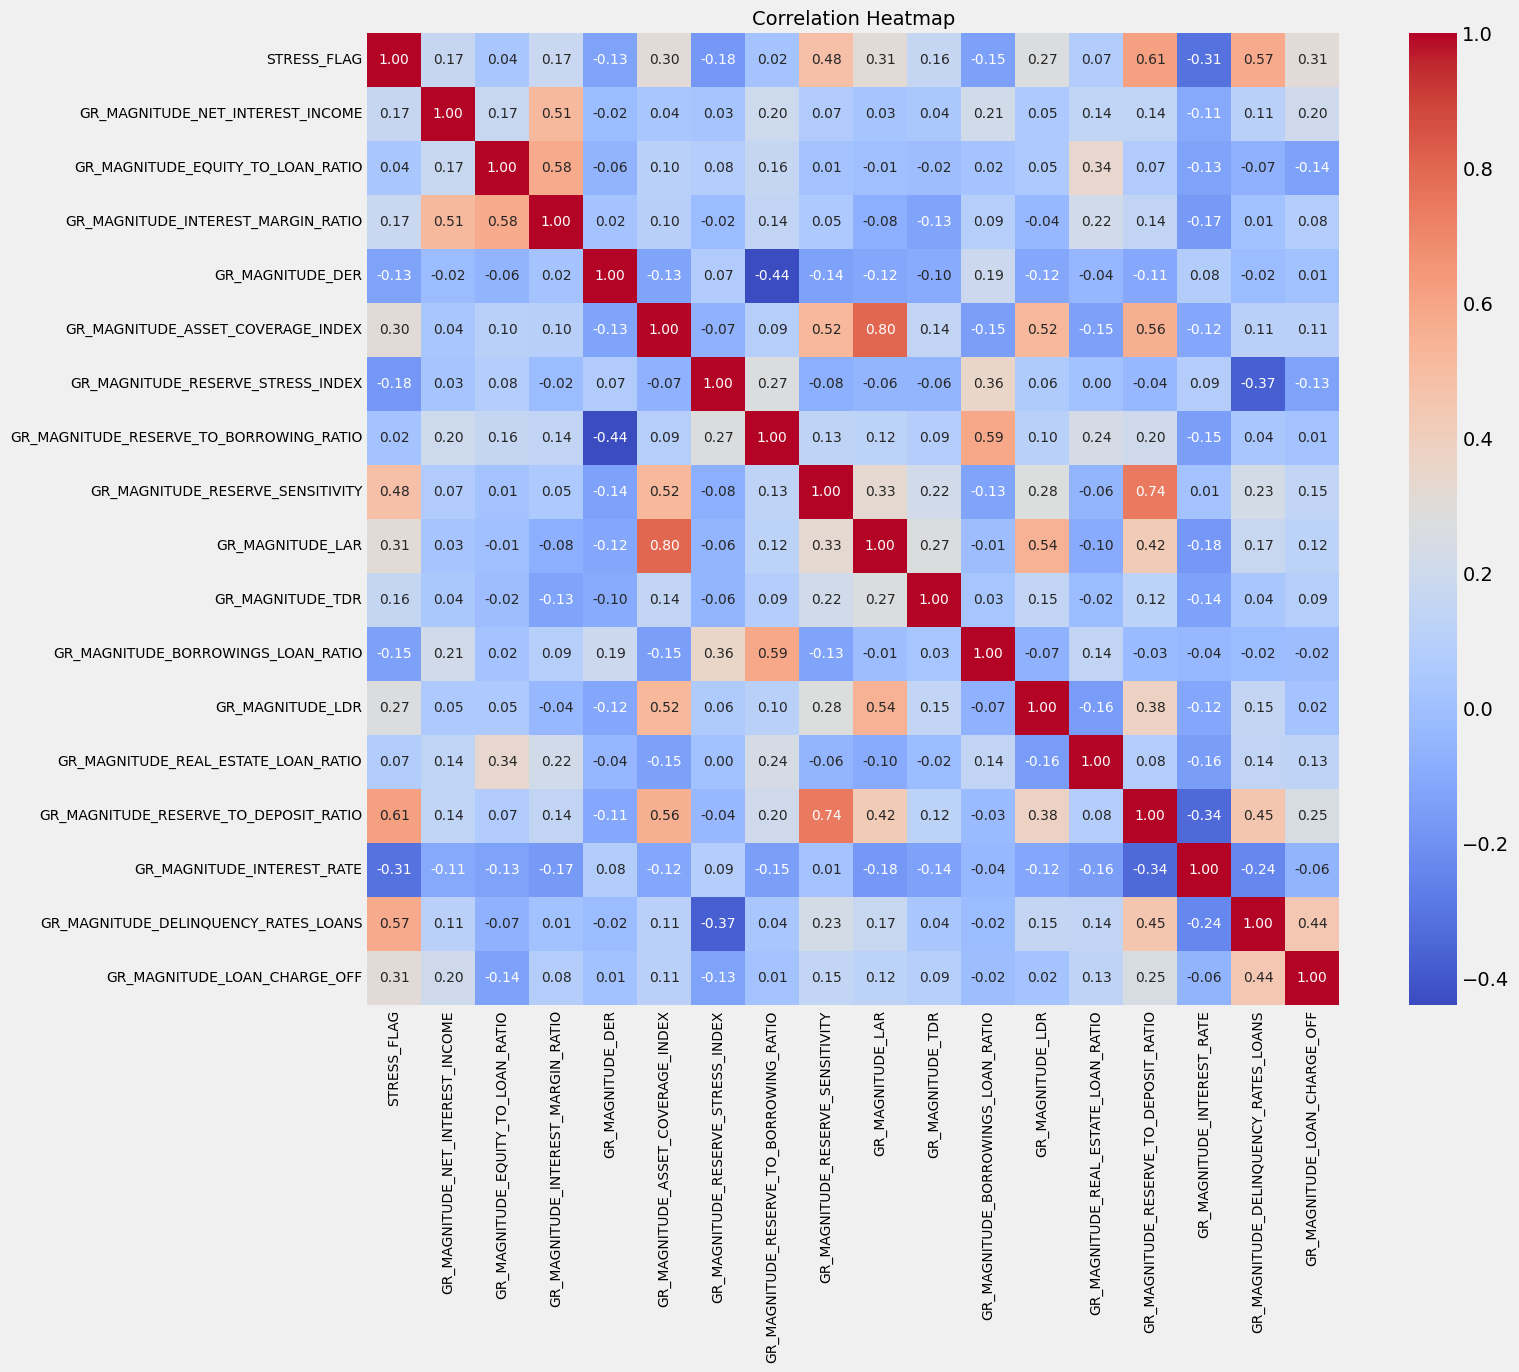

In [14]:
visualization_functions.heat_map_plot(cap_rec_df[pre_final_df])